In [1]:
# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

import matplotlib.path as mpath
import cartopy.feature as cfeature

from xgcm import Grid

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num

import gsw

import pyresample


In [15]:
# load grid
dg10 = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")
lat_rho_10 = dg10.variables["lat_rho"]
lon_rho_10 = dg10.variables["lon_rho"]
lat_u_10= dg10.variables["lat_u"]
lon_u_10 = dg10.variables["lon_u"]
lat_v_10= dg10.variables["lat_v"]
lon_v_10 = dg10.variables["lon_v"]
angle_10 = dg10.variables["angle"]
dg10.close()

# load wind stress from surface forcing
dg10 = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_sustr.nc")
sustr = dg10.variables["sustr"]
dg10.close()

dg10 = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_svstr.nc")
svstr = dg10.variables["svstr"]
dg10.close()

# load sfc heat/salt fluxes
dg10 = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_shflux.nc")
shflux = dg10.variables["shflux"]
dg10.close()
dg10 = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_swflux.nc")
swflux = dg10.variables["swflux"]
dg10.close()

# load wind stress from model output
dg10 = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_01-20yr/ocean_his_0020.nc")
sustr_mod = dg10.variables["sustr"]
svstr_mod = dg10.variables["svstr"]
dg10.close()

# load sfc fluxes from model output
dg10 = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_01-20yr/ocean_avg_0020.nc")
shflux_mod = dg10.variables["shflux"]
swflux_mod = dg10.variables["ssflux"]*(1/dg10.variables["salt"])
dg10.close()

In [130]:
print(sustr.shape)

# 2. interpolate to rho grid
w10_def = pyresample.geometry.SwathDefinition(lons=lon_rho_10,lats=lat_rho_10)
w10u_def = pyresample.geometry.SwathDefinition(lons=lon_u_10,lats=lat_u_10)
w10v_def = pyresample.geometry.SwathDefinition(lons=lon_v_10,lats=lat_v_10)

wf = lambda r: 1/r

# forcing
Ustr = np.empty([len(sustr[:,0,0]),lat_rho_10.shape[0],lat_rho_10.shape[1]])
Vstr = np.empty([len(sustr[:,0,0]),lat_rho_10.shape[0],lat_rho_10.shape[1]])
for dd in np.arange(0,len(sustr[:,0,0])):
    Ustr[dd,:,:] = pyresample.kd_tree.resample_custom(w10u_def,sustr[dd,:,:].values,w10_def,\    # obs: sensitive to radius and neighbours;
                                        radius_of_influence=50000,neighbours=4,weight_funcs=wf)  # used 5000 radius and 1 neighbour and it 
    Vstr[dd,:,:] = pyresample.kd_tree.resample_custom(w10v_def,svstr[dd,:,:].values,w10_def,\    # masked out values south of 70S
                                        radius_of_influence=50000,neighbours=4,weight_funcs=wf)
# model output    
mmax=12
Ustr_mod = np.empty([mmax,lat_rho_10.shape[0],lat_rho_10.shape[1]])
Vstr_mod = np.empty([mmax,lat_rho_10.shape[0],lat_rho_10.shape[1]])
for mm in np.arange(0,mmax):
    Ustr_mod[mm,:,:] = pyresample.kd_tree.resample_custom(w10u_def,sustr_mod[mm,:,:].values,w10_def,\
                                        radius_of_influence=50000,neighbours=4,weight_funcs=wf)
    Vstr_mod[mm,:,:] = pyresample.kd_tree.resample_custom(w10v_def,svstr_mod[mm,:,:].values,w10_def,\
                                        radius_of_influence=50000,neighbours=4,weight_funcs=wf)

# Forcing:
# annual mean
Ustr_ann = np.nanmean(Ustr, axis=0)
Vstr_ann = np.nanmean(Vstr, axis=0)
# winter mean (June-August)
di=151
df=243
Ustr_jja = np.nanmean(Ustr[di:df,:,:], axis=0)
Vstr_jja = np.nanmean(Vstr[di:df,:,:], axis=0)
shflux_jja = np.nanmean(shflux[di:df,:,:], axis=0)
swflux_jja = np.nanmean(swflux[di:df,:,:], axis=0)

# Model output:
# annual mean
Ustr_mod_ann = np.nanmean(Ustr_mod, axis=0)
Vstr_mod_ann = np.nanmean(Vstr_mod, axis=0)
# winter mean (June-August)
Ustr_mod_jja = np.nanmean(Ustr_mod[5:7,:,:], axis=0)
Vstr_mod_jja = np.nanmean(Vstr_mod[5:7,:,:], axis=0)
shflux_mod_jja = np.nanmean(shflux_mod[5:7:,:,:], axis=0)
swflux_mod_jja = np.nanmean(shflux_mod[5:7:,:,:], axis=0)


(365, 560, 629)


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/pyresample/kd_tree.py:384: UserWarning: Possible more than 4 neighbours within 50000 m for some data points
  warnings.warn(('Possible more than %s neighbours '
/jobfs/71979160.gadi-pbs/ipykernel_139931/700361454.py:42: RuntimeWarning: Mean of empty slice
  Ustr_mod_ann = np.nanmean(Ustr_mod, axis=0)
/jobfs/71979160.gadi-pbs/ipykernel_139931/700361454.py:43: RuntimeWarning: Mean of empty slice
  Vstr_mod_ann = np.nanmean(Vstr_mod, axis=0)
/jobfs/71979160.gadi-pbs/ipykernel_139931/700361454.py:45: RuntimeWarning: Mean of empty slice
  Ustr_mod_jja = np.nanmean(Ustr_mod[5:7,:,:], axis=0)
/jobfs/71979160.gadi-pbs/ipykernel_139931/700361454.py:46: RuntimeWarning: Mean of empty slice
  Vstr_mod_jja = np.nanmean(Vstr_mod[5:7,:,:], axis=0)
/jobfs/71979160.gadi-pbs/ipykernel_139931/700361454.py:47: RuntimeWarning: Mean of empty slice
  shflux_mod_jja = np.nanmean(shflux_mod[5:7:,:,:], axis=0)
/jobfs/71979160.ga

In [9]:
# days til 1st June
# 31: Jan, Mar, May
# 30: April
# 28: Feb
# total = 151

# days til 31st Augst
# 31: Jan, Mar, May, Jul, Aug
# 30: April, Jun
# 28: Feb
# total = (31*5)+60+28 = 243

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell ed

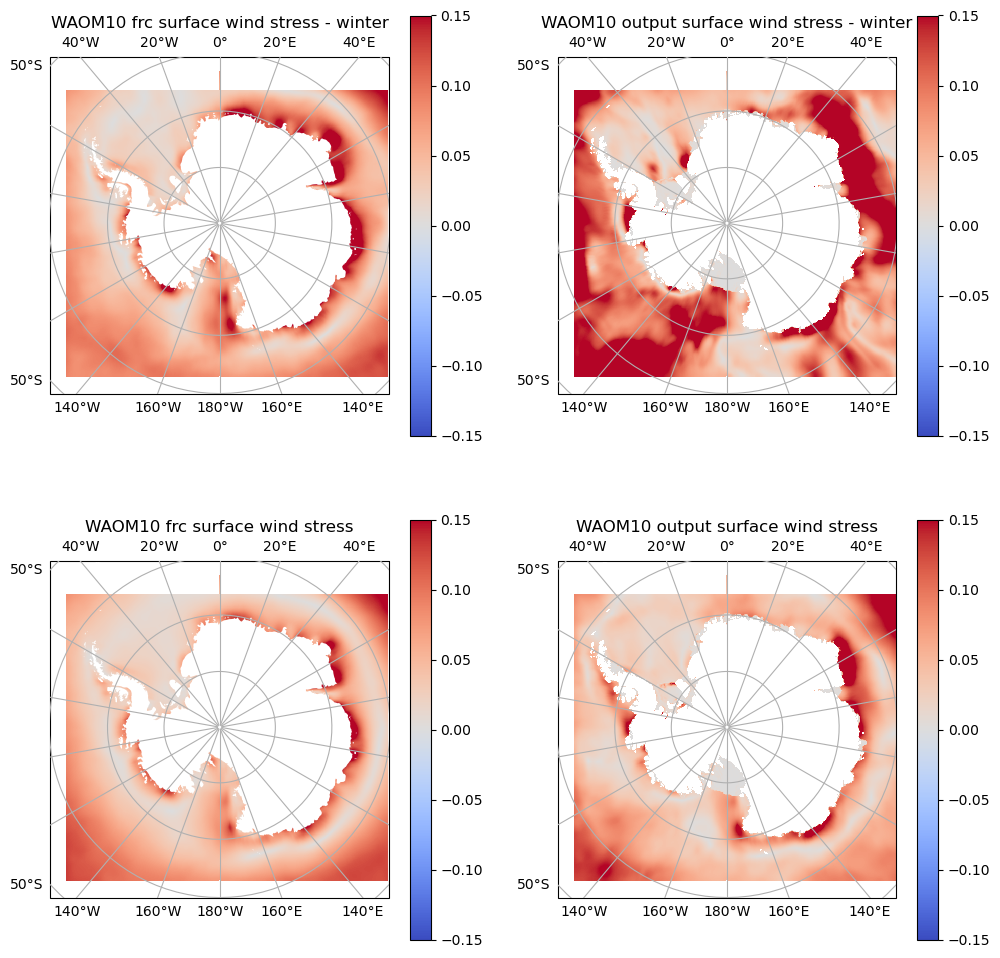

In [132]:
# plot to compare with Si et al (2022): winter (jun-aug) zonal wind speed
# I've wind stress and zonal/meridional don't match

proj = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(2,2,1, projection=proj)
ctf = plt.pcolormesh(lon_rho_10, lat_rho_10, np.sqrt(np.power(Ustr_jja,2)+np.power(Vstr_jja,2)), transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.15, vmax=.15)
# ctf = plt.pcolormesh(lon_rho_10, lat_rho_10, Ustr_ann, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.15, vmax=.15)
# ctf = plt.pcolormesh(lon_rho_10, lat_rho_10, Ustr_jja, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.15, vmax=.15)
gl = ax1.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,20))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-10))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.set_extent([-180, 180, -60, -90], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, zorder=3, facecolor='white') 
plt.title('WAOM10 frc surface wind stress - winter')
plt.colorbar()

ax2 = fig.add_subplot(2,2,2, projection=proj)
ctf = plt.pcolormesh(lon_rho_10, lat_rho_10, np.sqrt(np.power(Ustr_mod_jja,2)+np.power(Vstr_mod_jja,2)), transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.15, vmax=.15)
gl = ax2.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,20))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-10))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax2.set_extent([-180, 180, -60, -90], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND, zorder=3, facecolor='white') 
plt.title('WAOM10 output surface wind stress - winter')
plt.colorbar()

ax3 = fig.add_subplot(2,2,3, projection=proj)
ctf = plt.pcolormesh(lon_rho_10, lat_rho_10, np.sqrt(np.power(Ustr_ann,2)+np.power(Vstr_ann,2)), transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.15, vmax=.15)
gl = ax3.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,20))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-10))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax3.set_extent([-180, 180, -60, -90], crs=ccrs.PlateCarree())
ax3.add_feature(cfeature.LAND, zorder=3, facecolor='white') 
plt.title('WAOM10 frc surface wind stress')
plt.colorbar()

ax4 = fig.add_subplot(2,2,4, projection=proj)
ctf = plt.pcolormesh(lon_rho_10, lat_rho_10, np.sqrt(np.power(Ustr_mod_ann,2)+np.power(Vstr_mod_ann,2)), transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.15, vmax=.15)
gl = ax4.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,20))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-10))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax4.set_extent([-180, 180, -60, -90], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.LAND, zorder=3, facecolor='white') 
plt.title('WAOM10 output surface wind stress')
plt.colorbar()


plt.show()


In [133]:
# winds rotate by angle (b/w xi-axis and East-axis) to get zonal/meridional components

# - Scipy attempt; couldn't input a xarray matrix:
# from scipy.spatial.transform import Rotation as R

# r = R.from_euler('zyx', angle_10, degrees=True)
# print(angle_10.shape)
# print(r.as_matrix().shape)


In [134]:
print(angle_10.shape)

(560, 630)


In [135]:
# Manually build the ccw rotation matrix
t = angle_10
rotmat = np.empty(angle_10.shape)
Zon_str_ann = np.empty(angle_10.shape)
Mer_str_ann = np.empty(angle_10.shape)
Zon_str_jja = np.empty(angle_10.shape)
Mer_str_jja = np.empty(angle_10.shape)

Zon_mod_str_ann = np.empty(angle_10.shape)
Zon_mod_str_jja = np.empty(angle_10.shape)

for ii in np.arange(0,len(angle_10[:,0])):
    for jj in np.arange(0,len(angle_10[0,:])):
        # forcing:
        Zon_str_ann[ii,jj]= Ustr_ann[ii,jj]*np.cos(t[ii,jj]) - Vstr_ann[ii,jj]*np.sin(t[ii,jj])
        Mer_str_ann[ii,jj]= Ustr_ann[ii,jj]*np.sin(t[ii,jj]) + Vstr_ann[ii,jj]*np.cos(t[ii,jj])
        Zon_str_jja[ii,jj]= Ustr_jja[ii,jj]*np.cos(t[ii,jj]) - Vstr_jja[ii,jj]*np.sin(t[ii,jj])
        Mer_str_jja[ii,jj]= Ustr_jja[ii,jj]*np.sin(t[ii,jj]) + Vstr_jja[ii,jj]*np.cos(t[ii,jj])
        # model:
        Zon_mod_str_ann[ii,jj]= Ustr_mod_ann[ii,jj]*np.cos(t[ii,jj]) - Vstr_mod_ann[ii,jj]*np.sin(t[ii,jj])
        Zon_mod_str_jja[ii,jj]= Ustr_mod_jja[ii,jj]*np.cos(t[ii,jj]) - Vstr_mod_jja[ii,jj]*np.sin(t[ii,jj])
        
        


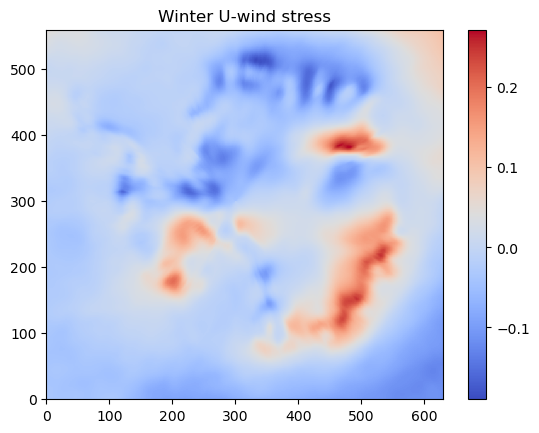

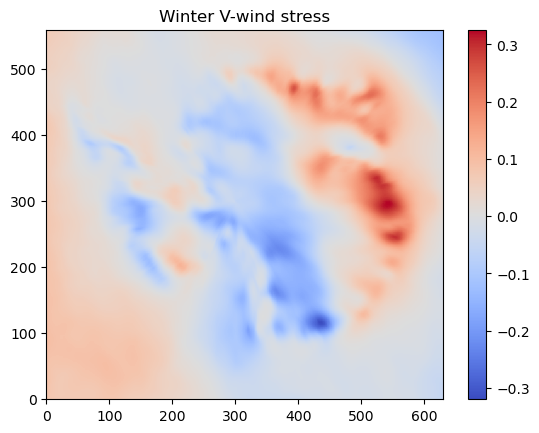

In [136]:
plt.pcolormesh(Ustr_jja, cmap=plt.cm.coolwarm)
plt.title('Winter U-wind stress')
plt.colorbar()
plt.show()

plt.pcolormesh(Vstr_jja, cmap=plt.cm.coolwarm)
plt.title('Winter V-wind stress')
plt.colorbar()
plt.show()

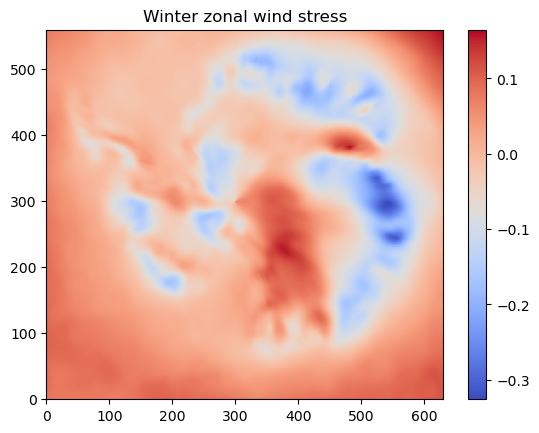

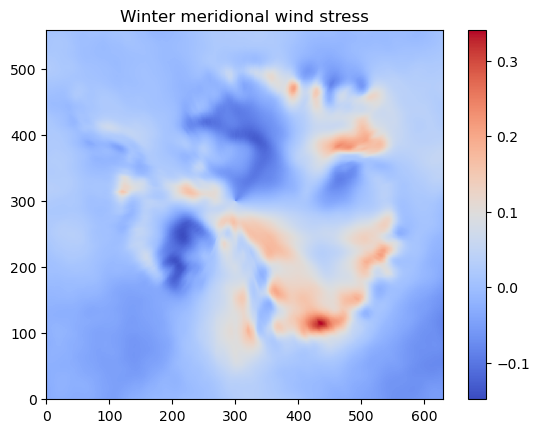

In [137]:
plt.pcolormesh(Zon_str_jja, cmap=plt.cm.coolwarm)
plt.title('Winter zonal wind stress')
plt.colorbar()
plt.show()

plt.pcolormesh(Mer_str_jja, cmap=plt.cm.coolwarm)
plt.title('Winter meridional wind stress')
plt.colorbar()
plt.show()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell ed

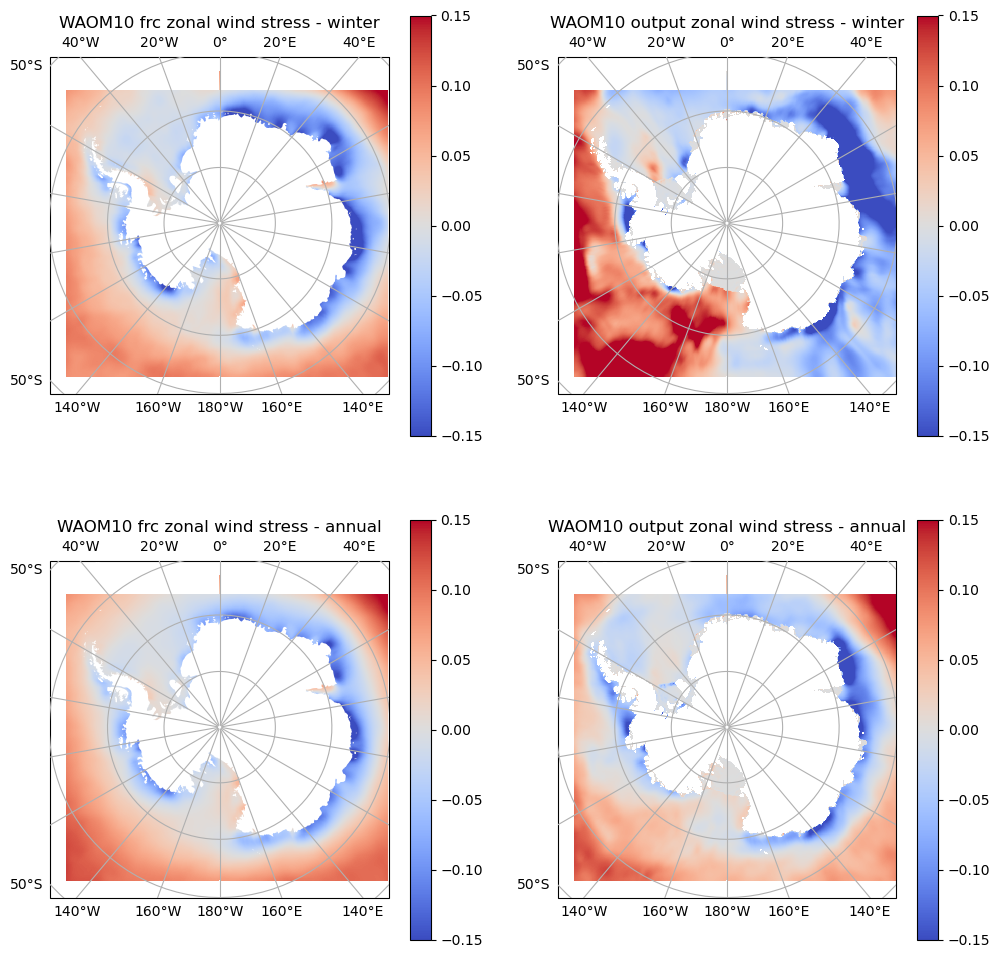

In [138]:
# plot to compare with Si et al (2022): winter (jun-aug) zonal wind speed
# I've wind stress and zonal/meridional don't match

proj = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(2,2,1, projection=proj)
ctf = plt.pcolormesh(lon_rho_10, lat_rho_10, Zon_str_jja, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.15, vmax=.15)
# ctf = plt.pcolormesh(lon_rho_10, lat_rho_10, Ustr_ann, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.15, vmax=.15)
# ctf = plt.pcolormesh(lon_rho_10, lat_rho_10, Ustr_jja, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.15, vmax=.15)
gl = ax1.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,20))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-10))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.set_extent([-180, 180, -60, -90], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, zorder=3, facecolor='white') 
plt.title('WAOM10 frc zonal wind stress - winter')
plt.colorbar()

ax2 = fig.add_subplot(2,2,2, projection=proj)
ctf = plt.pcolormesh(lon_rho_10, lat_rho_10, Zon_mod_str_jja, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.15, vmax=.15)
gl = ax2.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,20))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-10))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax2.set_extent([-180, 180, -60, -90], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND, zorder=3, facecolor='white') 
plt.title('WAOM10 output zonal wind stress - winter')
plt.colorbar()

ax3 = fig.add_subplot(2,2,3, projection=proj)
ctf = plt.pcolormesh(lon_rho_10, lat_rho_10, Zon_str_ann, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.15, vmax=.15)
gl = ax3.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,20))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-10))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax3.set_extent([-180, 180, -60, -90], crs=ccrs.PlateCarree())
ax3.add_feature(cfeature.LAND, zorder=3, facecolor='white') 
plt.title('WAOM10 frc zonal wind stress - annual')
plt.colorbar()

ax4 = fig.add_subplot(2,2,4, projection=proj)
ctf = plt.pcolormesh(lon_rho_10, lat_rho_10, Zon_mod_str_ann, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.15, vmax=.15)
gl = ax4.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,20))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-10))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax4.set_extent([-180, 180, -60, -90], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.LAND, zorder=3, facecolor='white') 
plt.title('WAOM10 output zonal wind stress - annual')
plt.colorbar()


plt.show()
